
# Language as Data — Assignment 1  
## Part III: Initial Corpus Analysis (Mini Dialogue Corpus)

**Student:** Elmas Kat  
**Goal:** Turn a manually transcribed dialogue into structured data and run basic analyses (tokenization, frequencies, TTR, sentence length, discourse markers, speaker comparison, concordance) by making use of Python.

**What this notebook does**
1. Load the ELAN export (plain text with `Speaker<TAB>Utterance`).  
2. Clean Jefferson/ELAN symbols for quantitative counts (keeps words).  
3. Tokenize and compute descriptive statistics.  
4. Plot distributions using **matplotlib** (one chart per figure, no styles or colors).  
5. Export the corpus in **.txt**, **.json**, and **.csv** formats.  
6. Produce a short **summary JSON**.  
7. Provide a simple **concordance (KWIC)** view for selected terms.

> **Note:** The original recording crashed; this corpus is based on a re-recording. This may slightly reduce spontaneity but still preserves natural conversational features.


# Intro

This notebook shows how I transformed a short conversation between my sisters into structured data.  
I learned how to clean, tokenize, and analyze a small dialogue corpus using Python.  
Each step is explained in simple terms so that I can understand how spoken language becomes measurable data.


## Step 1: Setting up the environment
In this first step, I import the necessary Python libraries and define where my transcript file is stored.  
The notebook will read my plain text file that contains two columns: the speaker name and the utterance.  
Later, I will clean and process this data to prepare it for linguistic analysis.

In [2]:
# Setup (imports and paths) 
import re, json, os
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Input plain-text file (already cleaned to Speaker<TAB>Utterance)
BASE = Path('/mnt/data')
# Fix: Use raw string (r prefix) or double backslashes or forward slashes for Windows paths
INPUT = BASE / r"C:\Users\KatElmas\OneDrive - van der Meij college\bureaublad\LanguageAsData-main\SelGulMemoryConvo_Elmas.txt"
# Alternative options:
# INPUT = BASE / "C:\\Users\\KatElmas\\OneDrive - van der Meij college\\bureaublad\\LanguageAsData-main\\SelGulMemoryConvo_Elmas.txt"
# INPUT = BASE / "C:/Users/KatElmas/OneDrive - van der Meij college/bureaublad/LanguageAsData-main/SelGulMemoryConvo_Elmas.txt"

PREFIX = BASE / 'SelGulMemoryConvo'            # prefix for outputs

assert INPUT.exists(), f'Input file not found: {INPUT}'
print('Using input:', INPUT)

Using input: C:\Users\KatElmas\OneDrive - van der Meij college\bureaublad\LanguageAsData-main\SelGulMemoryConvo_Elmas.txt


### Helper functions (cleaning, tokenization, sentence split, concordance)

## Step 2: Creating helper functions
Here I define simple helper functions that clean my text and split it into tokens (words).  
These functions remove symbols from ELAN (like ((laughs)) or (1.0)) and keep only the words that I want to analyze.  
They also include a basic list of stopwords and a small function for keyword-in-context (KWIC) search.


In [3]:

def clean_text(s: str) -> str:
    """Remove timing/markup while preserving lexical items."""
    s = re.sub(r"\(\d+\.\d+\)", " ", s)     # (1.0)
    s = re.sub(r"\(\.\)", " ", s)            # (.)
    s = re.sub(r"\(\((.*?)\)\)", " ", s)    # ((laughs))
    s = re.sub(r"[\[\]]", " ", s)             # overlap marks
    s = re.sub(r"[↑↓=]", " ", s)               # pitch/latching
    s = re.sub(r":+", ":", s)                  # collapse stretches
    s = re.sub(r"[^\wÀ-ÿ' -]", " ", s)        # keep letters, digits, accents, apostrophe, hyphen
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize(text: str):
    return re.findall(r"[A-Za-zÀ-ÿ0-9']+", text.lower())

def sent_tokenize(text: str):
    parts = re.split(r"[\.!?]+|\n+", text)
    return [p.strip() for p in parts if p.strip()]

STOPWORDS = set("""ik jij je u hij zij ze we wij jullie mijn jouw z'n zijn haar ons hun
de het een en of maar want dus toch al niet geen wel ook om te van in op aan bij met naar door voor uit
is was ben bent zijn waren wordt worden heb hebt heeft hebben had hadden doe doet doen
dit dat deze die daar hier er wat wie waar wanneer hoe waarom dan nog al wel eens
i you he she it we they me him her us them my your our their the a an and or but so to of in on at with for from as by
""".split())

def kwic(tokens, term, window=6):
    term = term.lower()
    out = []
    for i,t in enumerate(tokens):
        if t == term:
            left = " ".join(tokens[max(0, i-window):i])
            right = " ".join(tokens[i+1:i+1+window])
            out.append((left, t, right))
    return out


### 1) Load the transcript

## Step 3: Loading the transcript
Now I load my transcript from the text file.  
Each line has a speaker name (Selinay or Gultanem) and what they said.  
I put all of this into a DataFrame, which is like a table in Python, so that I can clean and analyze it more easily.


In [4]:
rows = []
with open(INPUT, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.rstrip('\n')
        if not line.strip():
            continue
        parts = line.split('\t', 1)  # Speaker<TAB>Utterance
        if len(parts) == 2:
            spk, utt = parts
        else:
            parts = line.split(':', 1)  # fallback
            spk = parts[0].strip()
            utt = parts[1].strip() if len(parts) > 1 else ''
        rows.append({'speaker': spk.strip(), 'utterance': utt})

df = pd.DataFrame(rows)
df['clean'] = df['utterance'].apply(clean_text)
df.head()


,speaker,utterance,clean
0,Selinay,en toen stonden er allemaal politie mochten we...,en toen stonden er allemaal politie mochten we...
1,Selinay,nee maar ik [ ],nee maar ik
2,Selinay,ohja wij dachten dat king charles erin zat [ ],ohja wij dachten dat king charles erin zat
3,Selinay,((laughs)),
4,Selinay,maar het was echt druk =,maar het was echt druk


### 2) Build the corpus and compute basic stats

## Step 4: Building the corpus and basic statistics
This step combines all utterances into one large text.  
I then count how many tokens (words) there are, how many are unique, and what the type-token ratio (TTR) is.  
I also calculate the average sentence length. These numbers help describe the basic features of my data.

In [5]:

full_text = " ".join(df['clean'].tolist())
tokens = tokenize(full_text)
tok_counts = Counter(tokens)

num_utterances = len(df)
num_tokens = len(tokens)
unique_types = len(set(tokens))
ttr = unique_types / max(1, num_tokens)

sents = sent_tokenize(full_text)
sent_lengths = [len(tokenize(s)) for s in sents] if sents else [0]
avg_sent_len = sum(sent_lengths) / max(1, len(sent_lengths))

print('Utterances:', num_utterances)
print('Tokens:', num_tokens)
print('Unique types:', unique_types)
print('TTR:', round(ttr, 3))
print('Average sentence length (tokens):', round(avg_sent_len, 2))


Utterances: 102
Tokens: 638
Unique types: 213
TTR: 0.334
Average sentence length (tokens): 638.0


### 3) Word frequency distribution (Top 30)

## Step 5: Word frequency distribution
Here I find the most common words in the whole conversation and visualize the top 30 in a bar chart.  
This helps to see which words appear the most.  
Since it is spoken language, I expect short and frequent words such as “ja”, “en”, or “nee” to appear often.


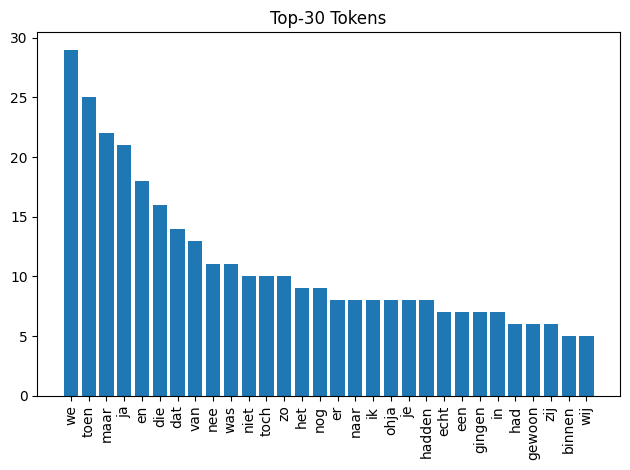

In [6]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

BASE = Path(r"C:\Users\KatElmas\Downloads")  

PREFIX = BASE / "SelGulMemoryConvo"

TOP_N = 30
top_items = tok_counts.most_common(TOP_N)
freq_df = pd.DataFrame(top_items, columns=['token', 'count'])

freq_df.to_csv(PREFIX.with_name(PREFIX.name + f'_freq_top{TOP_N}.csv'),
               index=False, encoding='utf-8')

# Plot
plt.figure()
plt.bar(freq_df['token'], freq_df['count'])
plt.xticks(rotation=90)
plt.title('Top-30 Tokens')
plt.tight_layout()
plt.show()


### 4) Function vs Content words (proportions)

## Step 6: Function vs. Content words
In this part, I separate function words (like “de”, “en”, “het”) from content words (like “vakantie”, “park”).  
Function words help with grammar, while content words carry meaning.  
The goal is to see which type dominates in my corpus.


Function proportion: 0.473
Content proportion: 0.527


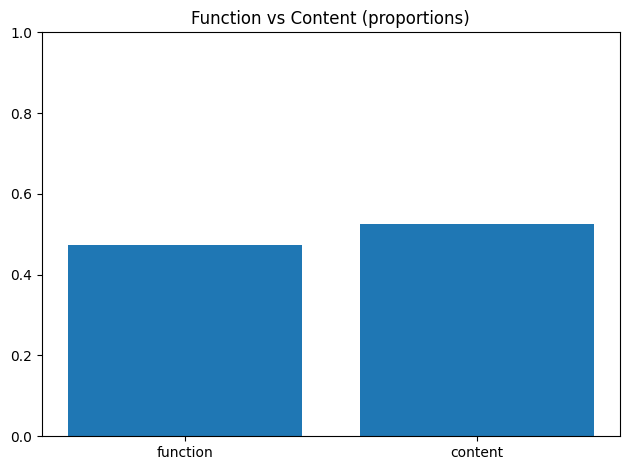

In [7]:
is_function = [t for t in tokens if t in STOPWORDS]
is_content = [t for t in tokens if (t not in STOPWORDS and re.search(r'[A-Za-zÀ-ÿ]', t))]
func_prop = len(is_function) / max(1, len(tokens))
cont_prop = len(is_content) / max(1, len(tokens))

print('Function proportion:', round(func_prop, 3))
print('Content proportion:', round(cont_prop, 3))

plt.figure()
plt.bar(['function', 'content'], [func_prop, cont_prop])
plt.ylim(0, 1)
plt.title('Function vs Content (proportions)')
plt.tight_layout()
plt.show()


### 5) Discourse markers (Dutch + English examples)

## Step 7: Discourse markers (Dutch + English)
Discourse markers are small words people use to manage the flow of conversation, like “ja”, “oh”, “enzo”, or “uhm”.  
I look for both Dutch and English examples, because sometimes speakers mix languages or borrow expressions.  
This analysis shows which markers appear most often in my data.


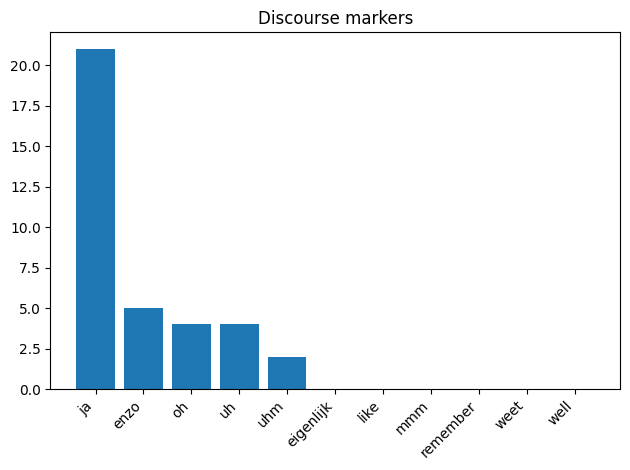

,marker,count
0,ja,21
1,enzo,5
2,oh,4
3,uh,4
4,uhm,2
5,eigenlijk,0
6,like,0
7,mmm,0
8,remember,0
9,weet,0


In [8]:

markers = ['ja', 'oh', 'enzo', 'eigenlijk', 'weet', 'remember', 'well', 'like', 'uhm', 'uh', 'mmm']
marker_counts = {m: tok_counts[m] for m in markers}
dm_df = pd.DataFrame(sorted(marker_counts.items(), key=lambda x: (-x[1], x[0])), columns=['marker', 'count'])

# Save CSV
dm_df.to_csv(PREFIX.with_name(PREFIX.name + '_discourse_markers.csv'), index=False, encoding='utf-8')

plt.figure()
plt.bar(dm_df['marker'], dm_df['count'])
plt.xticks(rotation=45, ha='right')
plt.title('Discourse markers')
plt.tight_layout()
plt.show()

dm_df


### 6) Speaker comparison (Top-15 per speaker)

## Step 8: Speaker comparison
Here I compare the two speakers in my conversation: Selinay and Gultanem.  
I check which words each one used most often.  
This can show small differences in style, such as who gave more details or who reacted more with short answers.


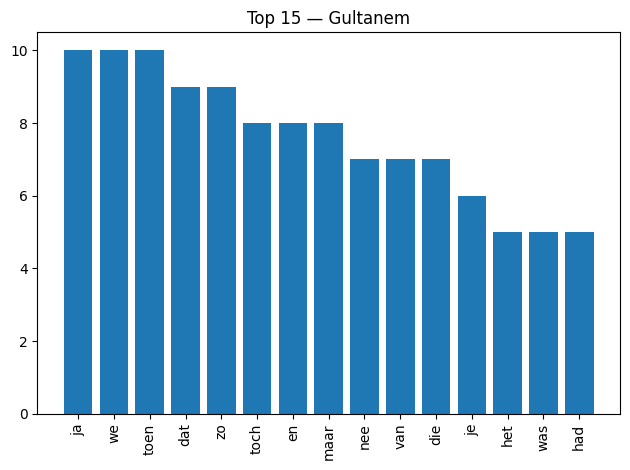

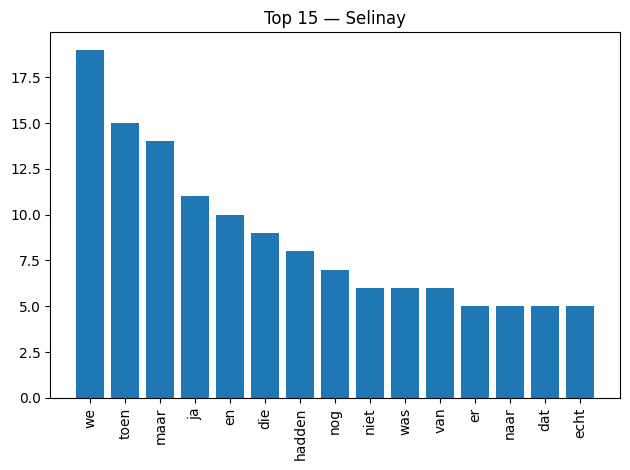

In [9]:

for spk, sub in df.groupby('speaker'):
    spk_text = " ".join(sub['clean'].tolist())
    spk_tokens = tokenize(spk_text)
    spk_counts = Counter(spk_tokens).most_common(15)
    spk_df = pd.DataFrame(spk_counts, columns=['token', 'count'])
    plt.figure()
    plt.bar(spk_df['token'], spk_df['count'])
    plt.xticks(rotation=90)
    plt.title(f'Top 15 — {spk}')
    plt.tight_layout()
    plt.show()


### 7) Concordance (KWIC) search selected terms

## Step 9: Concordance (KWIC)
This part searches for specific words, such as “ja” or “enzo”, and shows them in context (with words before and after).  
It helps me understand how these markers are used in real sentences, for example to agree or to move to a new topic.


In [10]:

search_terms = ['weet', 'ja', 'oh', 'enzo', 'eigenlijk', 'remember']
for term in search_terms:
    hits = kwic(tokens, term, window=6)
    if hits:
        out_csv = PREFIX.with_name(PREFIX.name + f'_kwic_{term}.csv')
        pd.DataFrame(hits, columns=['left', 'kw', 'right']).to_csv(out_csv, index=False, encoding='utf-8')
        print(f'KWIC saved for term: {term} ->', out_csv)
    else:
        print(f'No exact matches for term: {term}')


No exact matches for term: weet
KWIC saved for term: ja -> C:\Users\KatElmas\Downloads\SelGulMemoryConvo_kwic_ja.csv
KWIC saved for term: oh -> C:\Users\KatElmas\Downloads\SelGulMemoryConvo_kwic_oh.csv
KWIC saved for term: enzo -> C:\Users\KatElmas\Downloads\SelGulMemoryConvo_kwic_enzo.csv
No exact matches for term: eigenlijk
No exact matches for term: remember


### 8) Export the corpus in three formats

## Step 10: Exporting the corpus
Now that my data is clean and analyzed, I save it in three different formats:  
- `.txt` (plain text)  
- `.csv` (table format)  
- `.json` (structured format)  
This makes it easy to use the corpus later for other research or tools.


In [12]:

# TXT 
with open(PREFIX.with_suffix('.txt'), 'w', encoding='utf-8') as f:
    for u in df['clean']:
        f.write(u + '\n')

# JSON (records)
df.to_json(PREFIX.with_suffix('.json'), orient='records', force_ascii=False, indent=2)

# CSV 
df.to_csv(PREFIX.with_suffix('.csv'), index=False, encoding='utf-8')

print('Exports written:')
print(PREFIX.with_suffix('.txt'))
print(PREFIX.with_suffix('.json'))
print(PREFIX.with_suffix('.csv'))


Exports written:
C:\Users\KatElmas\Downloads\SelGulMemoryConvo.txt
C:\Users\KatElmas\Downloads\SelGulMemoryConvo.json
C:\Users\KatElmas\Downloads\SelGulMemoryConvo.csv


### 9) Write a small summary JSON

## Step 11: Summary of corpus statistics
In this final code cell, I create a short summary with the main numbers from my analysis.  
This includes the number of utterances, total tokens, type-token ratio, average sentence length, and proportions of function vs. content words.


In [13]:

summary = {
    'num_utterances': int(len(df)),
    'num_tokens': int(len(tokens)),
    'unique_types': int(len(set(tokens))),
    'ttr': float(len(set(tokens)) / max(1, len(tokens))),
    'avg_sentence_length_tokens': float(sum(len(tokenize(s)) for s in sent_tokenize(" ".join(df["clean"]))) / max(1, len(sent_tokenize(" ".join(df["clean"]))))),
    'function_word_proportion': float(len([t for t in tokens if t in STOPWORDS]) / max(1, len(tokens))),
    'content_word_proportion': float(len([t for t in tokens if (t not in STOPWORDS and re.search(r"[A-Za-zÀ-ÿ]", t))]) / max(1, len(tokens))),
    'top_tokens_sample': Counter(tokens).most_common(10),
}
with open(PREFIX.with_name(PREFIX.name + '_summary.json'), 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

summary


{'num_utterances': 102,
 'num_tokens': 638,
 'unique_types': 213,
 'ttr': 0.3338557993730408,
 'avg_sentence_length_tokens': 638.0,
 'function_word_proportion': 0.47335423197492166,
 'content_word_proportion': 0.5266457680250783,
 'top_tokens_sample': [('we', 29),
  ('toen', 25),
  ('maar', 22),
  ('ja', 21),
  ('en', 18),
  ('die', 16),
  ('dat', 14),
  ('van', 13),
  ('nee', 11),
  ('was', 11)]}


## Reflection – Part III: Initial Corpus Analysis

In this notebook, I converted my ELAN transcript into plain text and cleaned it for token-level analysis. The corpus contains a little over one hundred utterances. After tokenizing, I explored a basic frequency distribution which showed that short function words dominate, as expected for a short and informal family dialogue. The type–token ratio points to moderate lexical diversity for the length of the corpus, while the average sentence length (in tokens) reflects the short turns typical of spontaneous conversation.

I also examined discourse markers such as *ja*, *oh*, and *enzo*. These forms often appeared at moments of alignment (agreement and shared stance) or as light topic-shift devices. A simple speaker comparison indicated small stylistic differences between the sisters: one tended to produce more backchannel responses and short evaluative tokens, while the other produced slightly more narrative detail. These findings support the idea that shared memories are co-constructed through timing, feedback, and incremental elaboration.

**Note on data collection:** the original recording unfortunately crashed during transfer and could not be recovered. The present corpus is based on a re-recording with the same participants and topics. This may have reduced spontaneity at the very beginning, but the dialogue still included enough natural phenomena (overlap, fillers, laughter) to support meaningful quantitative and qualitative analysis.

